# Laboratorio 07 - Ejercicio 4 y 5: Comparaciones

### Librerías y parámetros

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

RNG_SEED = 12345
rng = np.random.RandomState(RNG_SEED)

N = 10000        
p = 0.3          
mu, sigma = 0.0, 1.0 


## Ejercicio 4
### Generación de muestra geométrica

In [22]:
teor_geom = stats.geom.rvs(p, size=N, random_state=rng)  # soporte 1,2,...

# Muestra "empírica" mediante transformada integral (inversa de la CDF)
u = rng.random(N)
emp_geom = stats.geom.ppf(u, p).astype(int)  # ppf hace la inversa exacta para geométrica

print("Ejercicio 4 — Geométrica")
print("  teor_geom: min, max, mean =", teor_geom.min(), teor_geom.max(), np.mean(teor_geom))
print("  emp_geom:  min, max, mean =", emp_geom.min(), emp_geom.max(), np.mean(emp_geom))


Ejercicio 4 — Geométrica
  teor_geom: min, max, mean = 1 30 3.3575
  emp_geom:  min, max, mean = 1 34 3.3656


### Pruebas (Chi-cuadrado discreta + KS de dos muestras) y visualizaciones

Geométrica — Chi2 (scipy-generated vs pmf): stat=16.545, p=0.4856
Geométrica — Chi2 (inverse-transform vs pmf): stat=9.197, p=0.9339
Geométrica — KS two-sample (scipy vs inverse): stat=0.0065, p=0.9841

Suma observados (teor) = 10000.0, suma esperados ajustados = 10000.0
Suma observados (emp)  = 10000.0, suma esperados ajustados = 10000.0


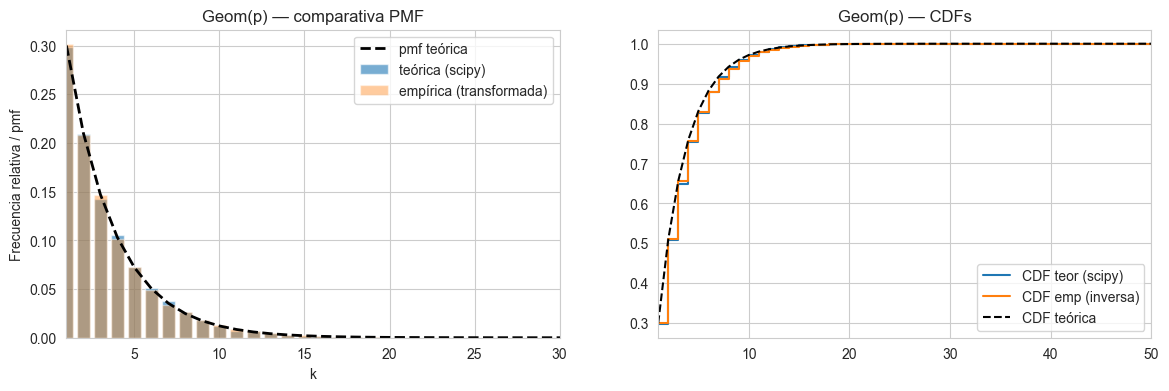

In [23]:
from collections import Counter

def chi2_discrete_test(obs_counts, expected_probs, N, min_expected=5):
    """
    obs_counts: array-like de conteos observados por bin (enteros)
    expected_probs: array-like de probabilidades teóricas por bin (suma ~1 para los bins considerados)
    N: tamaño de muestra (entero)
    Devuelve (chi2_stat, pval, observed_array, expected_array)
    Asegura que sum(expected)==sum(observed) ajustando la última celda tras agrupar si es necesario.
    """
    obs = np.asarray(obs_counts, dtype=float)
    exp = np.asarray(expected_probs, dtype=float) * N

    # Si longitudes difieren, extender expected con ceros (por seguridad)
    if len(obs) > len(exp):
        exp = np.pad(exp, (0, len(obs) - len(exp)), constant_values=0.0)
    elif len(exp) > len(obs):
        obs = np.pad(obs, (0, len(exp) - len(obs)), constant_values=0.0)

    # Agrupar cola si hay expected < min_expected
    mask_small = exp < min_expected
    if mask_small.any():
        idx_non_small = np.where(~mask_small)[0]
        if len(idx_non_small) == 0:
            raise ValueError("Todos los expected < {}: aumenta N o reduce número de bins.".format(min_expected))
        keep = idx_non_small[-1]
        observed = np.concatenate([obs[:keep], [obs[keep:].sum()]])
        expected = np.concatenate([exp[:keep], [exp[keep:].sum()]])
    else:
        observed = obs.copy()
        expected = exp.copy()

    # Asegurar que sumas coincidan (ajustar la última entrada expected)
    diff = observed.sum() - expected.sum()
    if abs(diff) > 1e-8 * max(1.0, observed.sum()):
        expected[-1] += diff  # corrige redondeo residual

    # Chequeo final (seguro)
    if not np.isclose(observed.sum(), expected.sum(), rtol=1e-8, atol=1e-12):
        raise ValueError("Suma de esperados aún no coincide con observados después de ajuste.")

    chi2_stat, pval = stats.chisquare(observed, f_exp=expected)
    return chi2_stat, pval, observed, expected

# Preparar conteos y pmf para geométrica
K_max = max(int(teor_geom.max()), int(emp_geom.max()), 50)  # tope práctico
k_vals = np.arange(1, K_max+1)
pmf_vals = stats.geom.pmf(k_vals, p)

obs_counts_teor = np.array([np.sum(teor_geom == k) for k in k_vals])
obs_counts_emp  = np.array([np.sum(emp_geom  == k) for k in k_vals])

# Test Chi2 (con corrección)
chi2_t, pval_chi2_t, obs_t_adj, exp_t_adj = chi2_discrete_test(obs_counts_teor, pmf_vals, N)
chi2_e, pval_chi2_e, obs_e_adj, exp_e_adj = chi2_discrete_test(obs_counts_emp, pmf_vals, N)

# KS two-sample entre las dos muestras generadas
ks_stat, ks_pval = stats.ks_2samp(teor_geom, emp_geom)

print("Geométrica — Chi2 (scipy-generated vs pmf): stat={:.3f}, p={:.4f}".format(chi2_t, pval_chi2_t))
print("Geométrica — Chi2 (inverse-transform vs pmf): stat={:.3f}, p={:.4f}".format(chi2_e, pval_chi2_e))
print("Geométrica — KS two-sample (scipy vs inverse): stat={:.4f}, p={:.4f}".format(ks_stat, ks_pval))
print()
print("Suma observados (teor) = {}, suma esperados ajustados = {}".format(obs_t_adj.sum(), exp_t_adj.sum()))
print("Suma observados (emp)  = {}, suma esperados ajustados = {}".format(obs_e_adj.sum(), exp_e_adj.sum()))

# Visualizaciones
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].bar(k_vals, obs_counts_teor / N, alpha=0.6, label='teórica (scipy)')
ax[0].bar(k_vals, obs_counts_emp  / N, alpha=0.4, label='empírica (transformada)')
ax[0].plot(k_vals, pmf_vals, 'k--', lw=2, label='pmf teórica')
ax[0].set_xlim(1, min(30, K_max))
ax[0].set_xlabel('k')
ax[0].set_ylabel('Frecuencia relativa / pmf')
ax[0].legend()
ax[0].set_title('Geom(p) — comparativa PMF')

# CDFs
xs = np.arange(1, min(100,K_max)+1)
ax[1].step(xs, np.cumsum(obs_counts_teor[:len(xs)])/N, where='post', label='CDF teor (scipy)')
ax[1].step(xs, np.cumsum(obs_counts_emp[:len(xs)])/N, where='post', label='CDF emp (inversa)')
ax[1].plot(xs, stats.geom.cdf(xs, p), 'k--', label='CDF teórica')
ax[1].set_xlim(1, min(50,K_max))
ax[1].legend()
ax[1].set_title('Geom(p) — CDFs')
plt.show()


In [24]:
if 'teor_norm' not in globals() or 'emp_norm' not in globals():
    teor_norm = stats.norm.rvs(loc=mu, scale=sigma, size=N, random_state=rng)
    u2 = rng.random(N)
    emp_norm  = stats.norm.ppf(u2, loc=mu, scale=sigma)

print("Normal: medias y desviaciones")
print("  teor_norm: mean {:.6f}, std {:.6f}".format(np.mean(teor_norm), np.std(teor_norm, ddof=0)))
print("  emp_norm:  mean {:.6f}, std {:.6f}".format(np.mean(emp_norm),  np.std(emp_norm, ddof=0)))


Normal: medias y desviaciones
  teor_norm: mean 0.002465, std 1.008289
  emp_norm:  mean -0.003105, std 1.008401


## Ejercicio 5

### Generación de muestra normal

Normal — KS two-sample: stat=0.0078, p=0.9213
Normal — Chi2 (binned): stat=14.036, p=0.7816
Suma observados (binned) = 10000, suma esperados ajustados = 10000.0


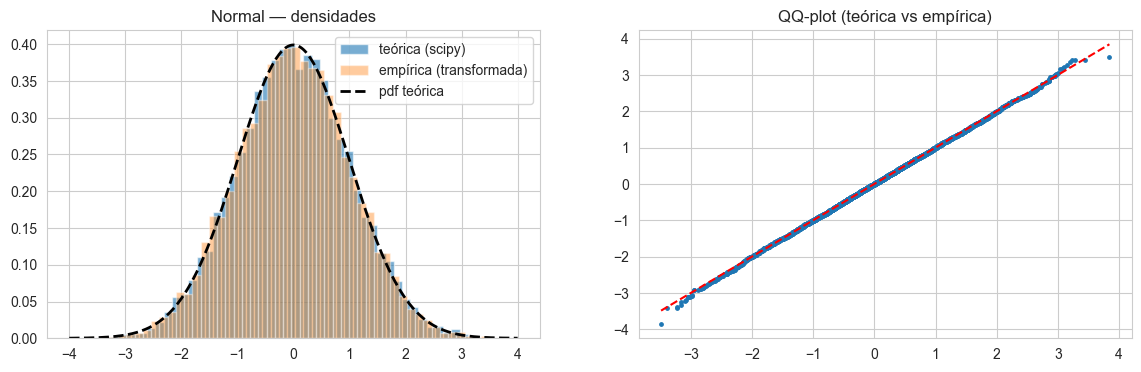

In [25]:
ks_stat_norm, ks_pval_norm = stats.ks_2samp(teor_norm, emp_norm)
print("Normal — KS two-sample: stat={:.4f}, p={:.4f}".format(ks_stat_norm, ks_pval_norm))

# Chi2 binned: histogram de la muestra empírica y probabilidades teóricas por bin
n_bins = 20
obs_counts, bin_edges = np.histogram(emp_norm, bins=n_bins)
cdf_vals = stats.norm.cdf(bin_edges, loc=mu, scale=sigma)
expected_probs = np.diff(cdf_vals)
expected_counts = expected_probs * N

# Agrupar/ajustar si expected_counts pequeños y asegurar suma
mask_small = expected_counts < 5
if mask_small.any():
    idx_non_small = np.where(~mask_small)[0]
    if len(idx_non_small) == 0:
        raise ValueError("Binning llevó expected <5 en todas las celdas. Aumenta N o reduce n_bins.")
    keep = idx_non_small[-1]
    observed_b = np.concatenate([obs_counts[:keep], [obs_counts[keep:].sum()]])
    expected_b = np.concatenate([expected_counts[:keep], [expected_counts[keep:].sum()]])
else:
    observed_b = obs_counts.astype(float)
    expected_b = expected_counts.astype(float)

# Ajuste para que sumas coincidan (corrige redondeos)
diff = observed_b.sum() - expected_b.sum()
if abs(diff) > 1e-8 * max(1.0, observed_b.sum()):
    expected_b[-1] += diff

# Chequeo final
if not np.isclose(observed_b.sum(), expected_b.sum(), rtol=1e-8, atol=1e-12):
    raise ValueError("Suma de esperados no coincide con observados tras ajuste (Normal).")

chi2_stat_norm, chi2_pval_norm = stats.chisquare(observed_b, f_exp=expected_b)
print("Normal — Chi2 (binned): stat={:.3f}, p={:.4f}".format(chi2_stat_norm, chi2_pval_norm))
print("Suma observados (binned) = {}, suma esperados ajustados = {}".format(observed_b.sum(), expected_b.sum()))

# Visualizaciones
fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].hist(teor_norm, bins=50, density=True, alpha=0.6, label='teórica (scipy)')
axes[0].hist(emp_norm,  bins=50, density=True, alpha=0.4, label='empírica (transformada)')
xs = np.linspace(mu-4*sigma, mu+4*sigma, 300)
axes[0].plot(xs, stats.norm.pdf(xs, mu, sigma), 'k--', lw=2, label='pdf teórica')
axes[0].legend()
axes[0].set_title('Normal — densidades')

# QQ plot entre las dos muestras (visual)
s_te = np.sort(teor_norm)
s_em = np.sort(emp_norm)
m = min(len(s_te), len(s_em))
axes[1].scatter(s_te[:m], s_em[:m], s=6)
axes[1].plot([s_te[:m].min(), s_te[:m].max()], [s_te[:m].min(), s_te[:m].max()], 'r--')
axes[1].set_title('QQ-plot (teórica vs empírica)')
plt.show()


In [26]:
alpha = 0.05

print("=== Interpretación propuesta (α = {:.2f}) ===".format(alpha))
print("Geométrica: Chi2 (empírica) p = {:.4f} -> {}".format(
    pval_chi2_e, "NO rechazar H0" if pval_chi2_e > alpha else "Rechazar H0"))
print("Geométrica: KS two-sample p = {:.4f} -> {}".format(
    ks_pval, "NO rechazar H0" if ks_pval > alpha else "Rechazar H0"))

print("\nNormal: KS two-sample p = {:.4f} -> {}".format(
    ks_pval_norm, "NO rechazar H0" if ks_pval_norm > alpha else "Rechazar H0"))
print("Normal: Chi2 (binned) p = {:.4f} -> {}".format(
    chi2_pval_norm, "NO rechazar H0" if chi2_pval_norm > alpha else "Rechazar H0"))



=== Interpretación propuesta (α = 0.05) ===
Geométrica: Chi2 (empírica) p = 0.9339 -> NO rechazar H0
Geométrica: KS two-sample p = 0.9841 -> NO rechazar H0

Normal: KS two-sample p = 0.9213 -> NO rechazar H0
Normal: Chi2 (binned) p = 0.7816 -> NO rechazar H0
